In [5]:
import pickle

import torch
import numpy as np
from tqdm.auto import tqdm

from src.experiment_handling import get_datasets, run_experiments, visualise_experiments, visualise_most_and_least_informative_samples, get_info_and_predictions, get_trained_model, test_model

from src.acquisition_functions import get_experiments
from src.acquisition_functions import predictive_entropy, mutual_information, variation_ratios, mean_standard_deviation, random

from src.networks import LeNet

torch.use_deterministic_algorithms(mode=True)

SEED = 1
MODEL_SAVE_PATH = '/Users/pascalpilz/Documents/Bsc Thesis/models/'
EXPERIMENT_SAVE_PATH = './Experiment Results/'

# Active Learning Experiments

In [ ]:
experiments = get_experiments(which_acq_funcs=['predictive_entropy',
                                               'mutual_information',
                                               'variation_ratios',
                                               'mean_standard_deviation',
                                               'random'
                                               ],
                              n_acquisition_steps=10,
                              n_samples_to_acquire=10,
                              pool_subset_size=5_000,
                              test_subset_size=2_000,
                              T=64,
                              n_epochs=200,
                              early_stopping=-1,
                              val_size=1_000,
                              n_runs=1,
                              seed=SEED,)

experiment_results, save_path = run_experiments(experiments)

/Users/pascalpilz/miniconda3/envs/al/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


KeyError: 'test_acc_ubound'

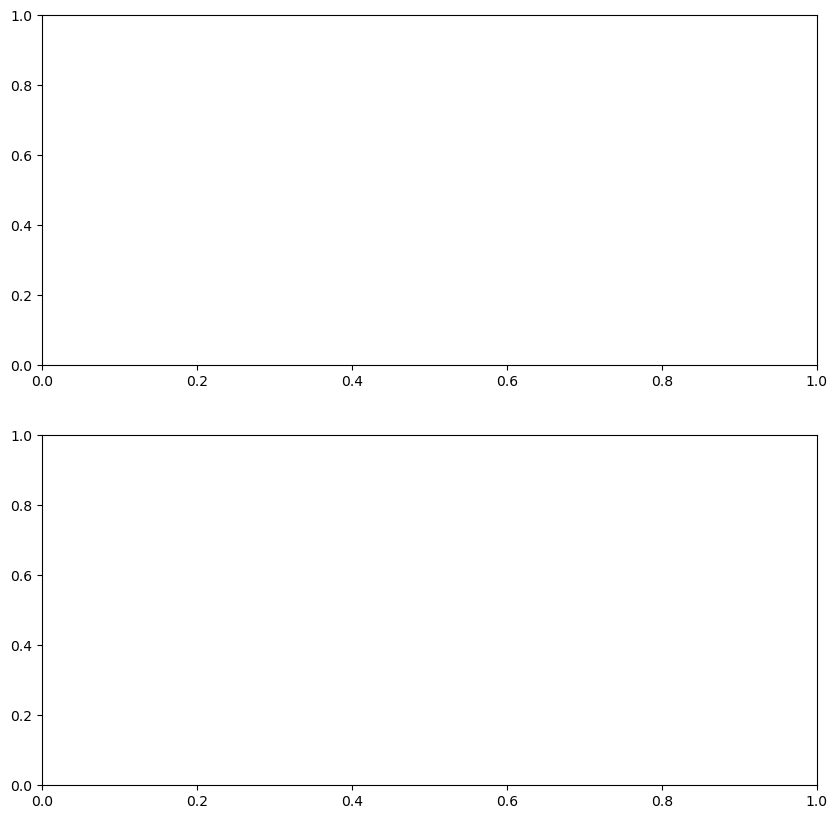

In [2]:
# save_path = EXPERIMENT_SAVE_PATH + 'expID-20240914_173249'
save_path = EXPERIMENT_SAVE_PATH + 'expID-20240914_173249'
with open(save_path, 'rb') as handle:
    loaded_experiment_results = pickle.load(handle)

visualise_experiments(loaded_experiment_results)

/Users/pascalpilz/miniconda3/envs/al/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


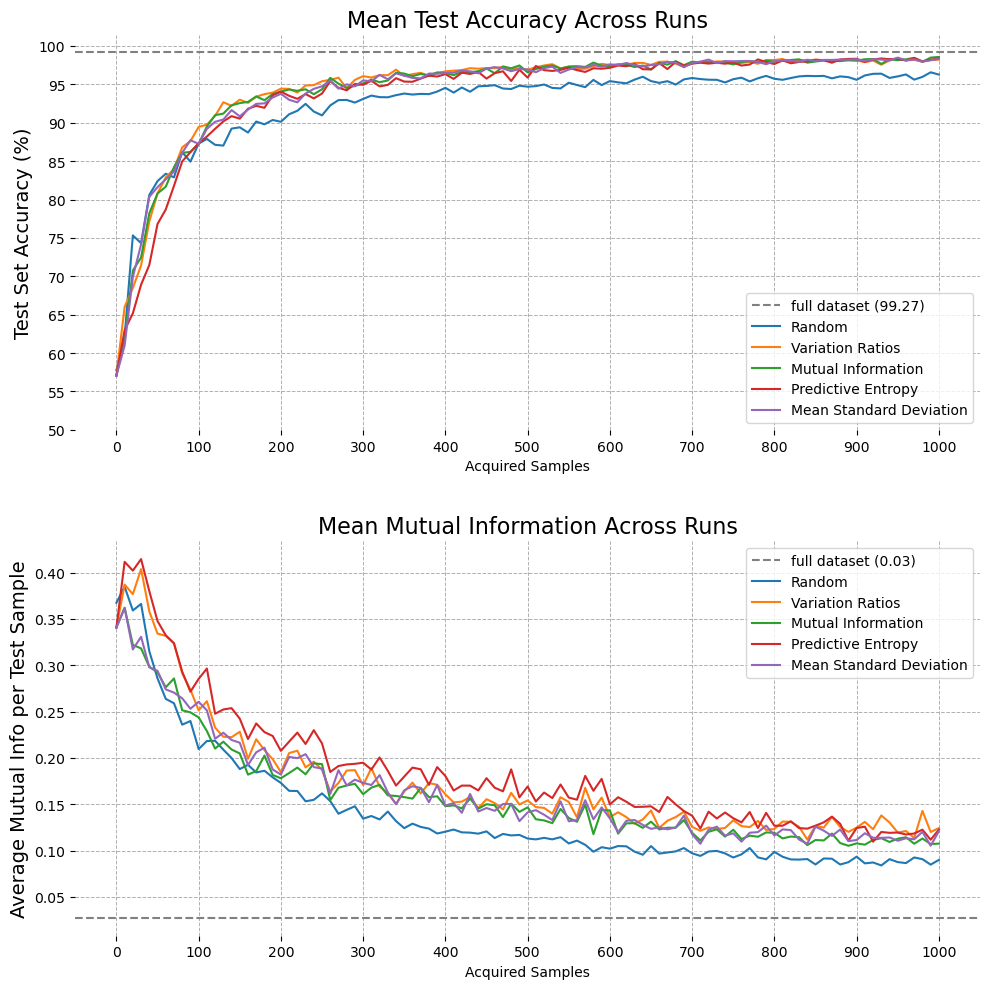

In [11]:
save_path = EXPERIMENT_SAVE_PATH + 'expID-20240914_173249'
with open(save_path, 'rb') as handle:
    loaded_experiment_results = pickle.load(handle)
   
# these values for accuracy and info are taken from the run expID-20241008_165627
loaded_experiment_results.append(
    {'test_acc_ubound': torch.Tensor([0.9920, 0.9932, 0.9929]),
     'test_inf_lbound': torch.Tensor([0.0269, 0.0283, 0.0273])}
)
    
visualise_experiments(loaded_experiment_results)

# Getting Upper Bound for Test Accuracy and Lower Bound for Test Information

In [8]:
from datetime import datetime

X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test = get_datasets(train_size=59_000, val_size=1_000)

train_set = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

val_set = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

torch.manual_seed(SEED)
np.random.seed(SEED)

infos = []
accs = []

model_path = (MODEL_SAVE_PATH
              + 'expID-' + datetime.now().strftime('%Y%m%d_%H%M%S') + '/')

for i in tqdm(range(3)):
    model_save_path = (model_path + 'run-' + str(i) + '/full_dataset/')

    model = get_trained_model(train_loader, val_loader, n_epochs=300, early_stopping=20, model_save_path=model_save_path)
    
    info, acc, _ = test_model(model, test_loader, T=64, show_pbar=True)
    
    infos.append(info)
    accs.append(acc)

  0%|          | 0/3 [00:00<?, ?it/s]

Training Model with Training size 59000: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 59000: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

Training Model with Training size 59000: 0it [00:00, ?it/s]

MC Dropout:   0%|          | 0/64 [00:00<?, ?it/s]

In [9]:
accs

[tensor(0.9920), tensor(0.9932), tensor(0.9929)]

# Getting Most and Least Informative Samples per Acquisition Function

In [4]:
X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test = get_datasets()

subset_idx = np.random.choice(range(X_pool.shape[0]), size=1_000, replace=False)
X_pool_subset = X_pool[subset_idx]
y_pool_subset = y_pool[subset_idx]

In [6]:
path = MODEL_SAVE_PATH + 'expID-20240909_184325/run-0/mutual_information/trainsize-00960_epoch-0119_valloss-0.123'
model = LeNet()
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

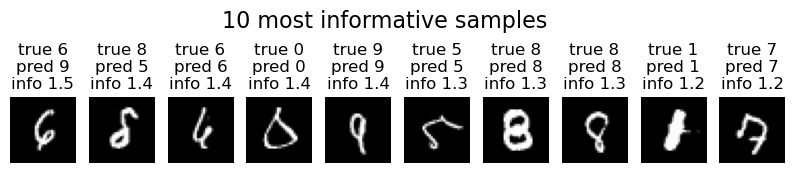

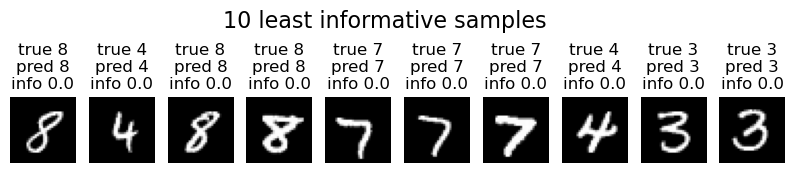

In [7]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=predictive_entropy)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

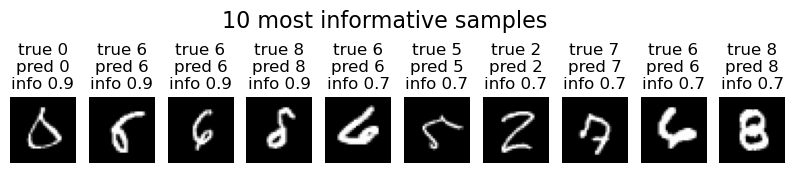

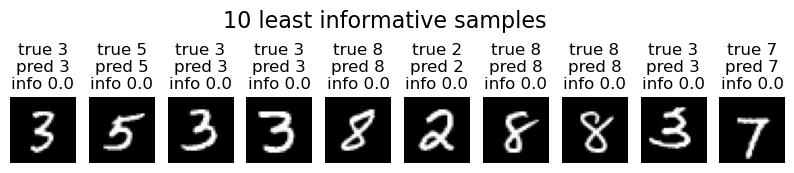

In [8]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=mutual_information)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

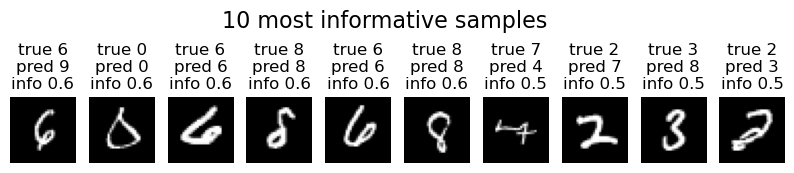

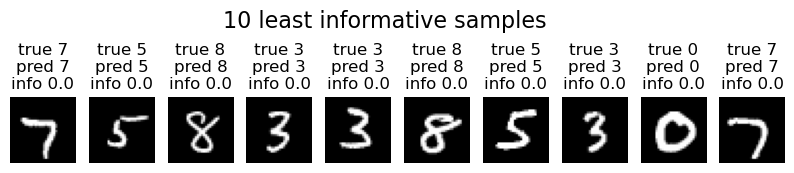

In [9]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=variation_ratios)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

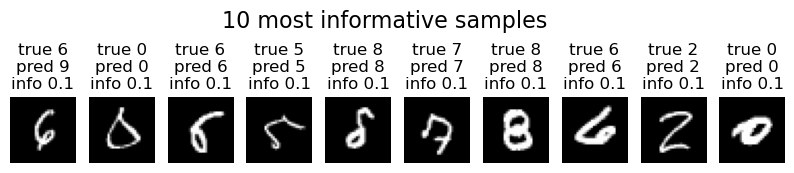

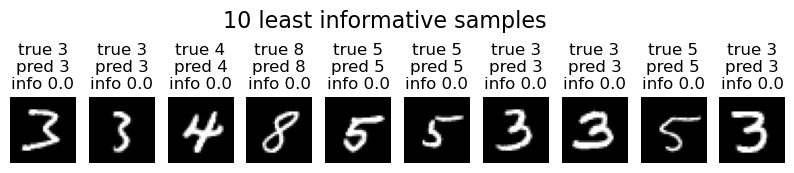

In [10]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=mean_standard_deviation)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)

MC Dropout:   0%|          | 0/10 [00:00<?, ?it/s]

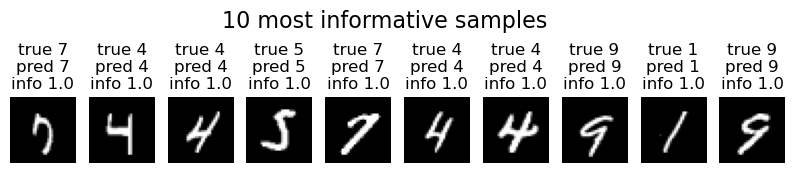

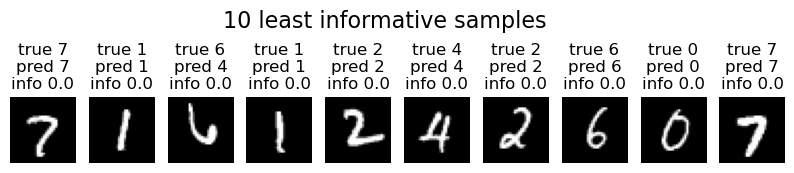

In [11]:
infos, preds, subset_idx\
    = get_info_and_predictions(model, X_pool_subset, show_pbar=True,
                               acquisition_function=random)
visualise_most_and_least_informative_samples(infos, preds,
                                             X_pool_subset, y_pool_subset)